In [1]:
import sys
import os

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from few.trajectory.inspiral import EMRIInspiral
from few.amplitude.romannet import RomanAmplitude
from few.amplitude.interp2dcubicspline import Interp2DAmplitude
from few.waveform import FastSchwarzschildEccentricFlux, SlowSchwarzschildEccentricFlux, GenerateEMRIWaveform
from few.utils.utility import (get_overlap,
                               get_mismatch,
                               get_fundamental_frequencies,
                               get_separatrix,
                               get_mu_at_t,
                               get_p_at_t,
                               get_kerr_geo_constants_of_motion,
                               xI_to_Y,
                               Y_to_xI)

from few.utils.ylm import GetYlms
from few.utils.modeselector import ModeSelector
from few.summation.interpolatedmodesum import CubicSplineInterpolant
from few.waveform import SchwarzschildEccentricWaveformBase
from few.summation.interpolatedmodesum import InterpolatedModeSum
from few.summation.directmodesum import DirectModeSum
from few.utils.constants import *
from few.summation.aakwave import AAKSummation
from few.waveform import Pn5AAKWaveform, AAKWaveformBase

In [2]:
use_gpu = False

# keyword arguments for inspiral generator (RunSchwarzEccFluxInspiral)
inspiral_kwargs={
        "DENSE_STEPPING": 0,  # we want a sparsely sampled trajectory
        "max_init_len": int(1e3),  # all of the trajectories will be well under len = 1000
    }

# keyword arguments for inspiral generator (RomanAmplitude)
amplitude_kwargs = {
    "max_init_len": int(1e3),  # all of the trajectories will be well under len = 1000
    "use_gpu": use_gpu  # GPU is available in this class
}

# keyword arguments for Ylm generator (GetYlms)
Ylm_kwargs = {
    "assume_positive_m": False  # if we assume positive m, it will generate negative m for all m>0
}

# keyword arguments for summation generator (InterpolatedModeSum)
sum_kwargs = {
    "use_gpu": use_gpu,  # GPU is availabel for this type of summation
    "pad_output": False,
}

# set omp threads one of two ways
num_threads = 4

# this is the general way to set it for all computations
from few.utils.utility import omp_set_num_threads
omp_set_num_threads(num_threads)

few = FastSchwarzschildEccentricFlux(
    inspiral_kwargs=inspiral_kwargs,
    amplitude_kwargs=amplitude_kwargs,
    Ylm_kwargs=Ylm_kwargs,
    sum_kwargs=sum_kwargs,
    use_gpu=use_gpu,
    num_threads=num_threads,  # 2nd way for specific classes
)

In [3]:
from few.utils.baseclasses import TrajectoryBase
from few.utils.constants import MTSUN_SI, YRSID_SI, Pi

class PnTrajectory(TrajectoryBase):
    def __init__(self, *args, **kwargs):
        kwargs_internal = kwargs.copy()
        if 'max_init_len' in kwargs:
            self.max_init_len_external = kwargs['max_init_len']
            max_init_len_internal = int(1e3)
            kwargs_internal['max_init_len'] = max_init_len_internal
        else:
            self.max_init_len_external = 150
        
        self.traj_module = EMRIInspiral(func='pn5', **kwargs_internal)
        pass
    
    def get_inspiral(self, M, mu, a, p0, e0, x0, T=1.0, **kwargs):
        kwargs_internal = kwargs.copy()
        if 'max_init_len' in kwargs:
            self.max_init_len_external = kwargs['max_init_len']
            max_init_len_internal = int(1e3)
            kwargs_internal['max_init_len'] = max_init_len_internal
            
        t, p, e, x, Phi_phi, Phi_theta, Phi_r = self.traj_module(M, mu, a, p0, e0, x0, T=T, **kwargs_internal)
        
        if t.shape[0] > self.max_init_len_external:
            new_t = (t[-1] - np.logspace(1., np.log10(t[-1]), self.max_init_len_external) + 10.)[::-1]
            t, p, e, x, Phi_phi, Phi_theta, Phi_r = self.traj_module(M, mu, a, p0, e0, x0, T=T, new_t=new_t, upsample=True, **kwargs_internal)
            
        return (t, p, e, x, Phi_phi, Phi_theta, Phi_r)
    
class PnAAK(AAKWaveformBase):
    def __init__(
        self,
        inspiral_kwargs={},
        sum_kwargs={},
        use_gpu=False,
        *args,
        **kwargs
    ):

        AAKWaveformBase.__init__(
            self,
            PnTrajectory,
            AAKSummation,
            inspiral_kwargs=inspiral_kwargs,
            sum_kwargs=sum_kwargs,
            use_gpu=use_gpu,
            num_threads=num_threads,
            *args,
            **kwargs
        )

    @property
    def gpu_capability(self):
        return True

    @property
    def allow_batching(self):
        return False

In [4]:
# traj_module = EMRIInspiral(func="SchwarzEccFlux")
inspiral_kwargs = {
    "DENSE_STEPPING": 0,  #we want a sparsely sampled trajectory
    "max_init_len": int(165),  # all of the trajectories will be well under len = 1000
}
traj_module_ref = EMRIInspiral(func="pn5", **inspiral_kwargs)
traj_module = PnTrajectory(**inspiral_kwargs)

# set initial parameters
z = 1.5
M = 5e5*(1+z)
mu = 1e1*(1+z)
e0 = 0.2

traj_args = [M, mu, 0.9, e0, 1.0]

t_out = 1.0
# run trajectory
p_new = get_p_at_t(
    traj_module,
    t_out,
    traj_args,
    traj_kwargs=inspiral_kwargs,
)

print('p0 = {} will create a waveform that is {} years long, given the other input parameters.'.format(p_new, t_out))

p0 = 8.609785945469952 will create a waveform that is 1.0 years long, given the other input parameters.


In [5]:
traj_module(M, mu, traj_args[2], p_new, e0, traj_args[4], T=t_out)[0].shape

(219,)

In [6]:
from few.utils.utility import get_separatrix

In [7]:
# set initial parameters
p0 = p_new

# run trajectory
t, p, e, x, Phi_phi, Phi_theta, Phi_r = traj_module(M, mu, traj_args[2], p_new, e0, traj_args[4], T=t_out, max_init_len=160)
#t2, p2, e2, x2, Phi_phi2, Phi_theta2, Phi_r2 = traj_module_ref(M, mu, traj_args[2], p_new, e0, traj_args[4], T=t_out, max_init_len=160)
t[-1]/YRSID_SI

0.9999999924190711

In [8]:
from scipy.optimize import brentq
def get_at_t_nb(
    traj_module,
    traj_args,
    bounds,
    t_out,
    index_of_interest,
    traj_kwargs={},
    xtol=2e-12,
    rtol=8.881784197001252e-16,
):
    """Root finding wrapper using Brent's method.

    This function uses scipy's brentq routine to find root.

    arguments:
        traj_module (obj): Instantiated trajectory module. It must output
            the time array of the trajectory sparse trajectory as the first
            output value in the tuple.
        traj_args (list): List of arguments for the trajectory function.
            p is removed. **Note**: It must be a list, not a tuple because the
            new p values are inserted into the argument list.
        bounds (list): Minimum and maximum values over which brentq will search for a root.
        t_out (double): The desired length of time for the waveform.
        index_of_interest (int): Index where to insert the new values in
            the :code:`traj_args` list.
        traj_kwargs (dict, optional): Keyword arguments for :code:`traj_module`.
            Default is an empty dict.
        xtol (float, optional): Absolute tolerance of the brentq root-finding - see :code: `np.allclose()` for details.
            Defaults to 2e-12 (scipy default).
        rtol (float, optional): Relative tolerance of the brentq root-finding - see :code: `np.allclose()` for details.
            Defaults to ~8.8e-16 (scipy default).

    returns:
        double: Root value.

    """

    def get_time_root(val, traj, inj_args, traj_kwargs, t_out, ind_interest):
        """
        Function with one p root at T = t_outp, for brentq input.
        """
        inputs = inj_args.copy()
        inputs.insert(ind_interest, val)
        traj_kwargs["T"] = t_out * 2.0
        out = traj(*inputs, **traj_kwargs)
        return out[0][-1] - t_out * YRSID_SI
    
    root = brentq(
        get_time_root,
        bounds[0],
        bounds[1],
        xtol=xtol,
        rtol=rtol,
        args=(traj_module, traj_args, traj_kwargs, t_out, index_of_interest),
    )
    return root

def get_p_at_t_nb(
    traj_module,
    t_out,
    traj_args,
    index_of_p=3,
    index_of_a=2,
    index_of_e=4,
    index_of_x=5,
    bounds=None,
    **kwargs,
):
    """Find the value of p that will give a specific length inspiral using Brent's method.

    If you want to generate an inspiral that is a specific length, you
    can adjust p accordingly. This function tells you what that value of p
    is based on the trajectory module and other input parameters at a
    desired time of observation.

    This function uses scipy's brentq routine to find the (presumed only)
    value of p that gives a trajectory of duration t_out.

    arguments:
        traj_module (obj): Instantiated trajectory module. It must output
            the time array of the trajectory sparse trajectory as the first
            output value in the tuple.
        t_out (double): The desired length of time for the waveform.
        traj_args (list): List of arguments for the trajectory function.
            p is removed. **Note**: It must be a list, not a tuple because the
            new p values are inserted into the argument list.
        index_of_p (int, optional): Index where to insert the new p values in
            the :code:`traj_args` list. Default is 3.
        index_of_a (int, optional): Index of a in provided :code:`traj_module` arguments. Default is 2.
        index_of_e (int, optional): Index of e0 in provided :code:`traj_module` arguments. Default is 4.
        index_of_x (int, optional): Index of x0 in provided :code:`traj_module` arguments. Default is 5.
        bounds (list, optional): Minimum and maximum values of p over which brentq will search for a root.
            If not given, will be set to [separatrix + 0.101, 50]. To supply only one of these two limits, set the
            other limit to None.
        **kwargs (dict, optional): Keyword arguments for :func:`get_at_t`.

    returns:
        double: Value of p that creates the proper length trajectory.

    """

    # fix indexes for p
    if index_of_a > index_of_p:
        index_of_a -= 1
    if index_of_e > index_of_p:
        index_of_e -= 1
    if index_of_x > index_of_p:
        index_of_x -= 1

    if "traj_kwargs" in kwargs and "enforce_schwarz_sep" in kwargs["traj_kwargs"]:
        enforce_schwarz_sep = kwargs["traj_kwargs"]["enforce_schwarz_sep"]
    else:
        enforce_schwarz_sep = False

    # fix bounds
    if bounds is None:
        if not enforce_schwarz_sep:
            p_sep = get_separatrix(
                traj_args[index_of_a], traj_args[index_of_e], traj_args[index_of_x]
            )  # should be fairly close.
        else:
            p_sep = 6 + 2 * traj_args[index_of_e]
        bounds = [p_sep + 0.1, 16.0 + 2 * traj_args[index_of_e]]

    elif bounds[0] is None:
        if not enforce_schwarz_sep:
            p_sep = get_separatrix(
                traj_args[index_of_a], traj_args[index_of_e], traj_args[index_of_x]
            )  # should be fairly close.
        else:
            p_sep = 6 + 2 * traj_args[index_of_e]
        bounds[0] = p_sep + 0.1

    elif bounds[1] is None:
        bounds[1] = 16.0 + 2 * traj_args[index_of_e]

    root = get_at_t_nb(traj_module, traj_args, bounds, t_out, index_of_p, **kwargs)
    return root

In [9]:
get_at_t_nb(traj_module,
    traj_args,
    [8., 16.],
    1.,
    3, {'DENSE_STEPPING': 0, 'max_init_len': 165, 'T': 2.0})

8.609785919689404

In [10]:
get_p_at_t_nb(traj_module,
    t_out,
    traj_args,
    traj_kwargs=inspiral_kwargs)

8.609785945469952

In [1]:
import numpy as np
from eryn.state import State
from eryn.ensemble import EnsembleSampler
from eryn.prior import ProbDistContainer, uniform_dist
import corner

from eryn.moves import StretchMove

from lisatools.sensitivity import get_sensitivity

import prep_emri
from prep_emri import PnTrajectory, PnAAK
from few.trajectory.inspiral import EMRIInspiral
from few.utils.utility import get_p_at_t

In [2]:
prep_emri.lisa_gpu_path='/Users/znasipak/Documents/Projects/skyLocalization/lisa-on-gpu/'
use_gpu = False

# set parameters
M = 5e5
mu = 10.0
a = 0.01  # will be ignored in Schwarzschild waveform
p0 = 16.0
e0 = 0.01
x0 = 1.0  # will be ignored in Schwarzschild waveform
dist = 1.0  # distance
qK = 0.2  # polar spin angle
phiK = 0.2  # azimuthal viewing angle
qS = 0.3  # polar sky angle
phiS = 0.3  # azimuthal viewing angle
Phi_phi0 = 1.0
Phi_theta0 = 0.0
Phi_r0 = 3.0

Tobs = 2.0
dt = 15.

emri_injection_params = np.array([
        M,  
        mu, 
        a,
        p0, 
        e0, 
        x0,
        dist,
        qK, 
        phiK, 
        qS, 
        phiS,  
        Phi_phi0, 
        Phi_theta0, 
        Phi_r0
])

# set parameters
emri_injection_params_dict = {
        'M':  M,  
        'mu': mu, 
        'a':  a, # will be ignored in Schwarzschild waveform
        'p0': p0, 
        'e0': e0, 
        'x0': x0,   # will be ignored in Schwarzschild waveform
        'dist': dist, # Gpc 
        'qK': qK,   # polar spin angle
        'phiK':phiK,  # azimuthal 
        'qS': qS,   # polar sky angle 
        'phiS': phiS, # azimuthal 
        'Phi_phi0':  Phi_phi0,  
        'Phi_theta0':Phi_theta0, 
        'Phi_r0':    Phi_r0
}
    
sampling_pars="lnM,mu,p0,e0,dist,cosqS,phiS,cosqK,phiK,Phi_phi0,Phi_r0".split(',')
    
#priors
priors_dict={
                'lnM': uniform_dist(np.log(1e5), np.log(5e6)),  # M
                'mu': uniform_dist(1.0, 100.0),  # mu
                'p0': uniform_dist(9.0, 16.0),  # p0 #raised LB from 8 bc crash at p/e=8.35/0.65
                'e0': uniform_dist(0.001, 0.7),  # e0
                'dist': uniform_dist(0.01, 100.0),  # dist in Gpc
                'cosqK': uniform_dist(-0.99999, 0.99999),  # qK
                'phiK': uniform_dist(0.0, 2 * np.pi),  # phiK
                'cosqS': uniform_dist(-0.99999, 0.99999),  # qS
                'phiS': uniform_dist(0.0, 2 * np.pi),  # phiS
                'Phi_phi0': uniform_dist(0.0, 2 * np.pi),  # Phi_phi0
                'Phi_r0': uniform_dist(0.0, 2 * np.pi),  # Phi_r0
}

ntemps = 4
nwalkers = 30

waveform_kwargs = {
   "eps": 1e-2
}

waveform_kwargs_aak = {
}

In [7]:
wave_model=PnAAK(inspiral_kwargs={'max_init_len':150},sum_kwargs={"pad_output":True},num_threads=2)
%timeit h=wave_model(5e5, 10., 0.01, 11.6, 0.01, 0.99, dist=10., T=2.0, dt=15., qS=0., phiS=0., qK=0., phiK=0.)

799 ms ± 8.54 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


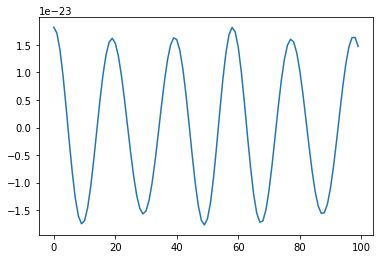

In [4]:
import matplotlib.pyplot as plt
plt.plot(h.real[:100])

In [5]:
# function call
def run_emri_snr(
    emri_prep, 
    emri_kwargs={}
):

    wave_gen=emri_prep['wave_gen']
    priors=emri_prep['priors']
    like = emri_prep['like']
    injection_params=emri_prep['injection_params']
    waveform_model=emri_prep['waveform_model']
    
    # get XYZ
    data_channels = wave_gen(*injection_params, **emri_kwargs)
    nchannels=2
    
    #For SNR calc we set the injected signal to 0
    like.inject_signal(
        data_stream=[0*data_channels[i] for i in range(nchannels)],
        noise_fn=get_sensitivity,
        noise_kwargs=[{"sens_fn": "noisepsd_AE", "model": "SciRDv1", "includewd": None} for _ in range(nchannels)],
        noise_args=[[] for _ in range(nchannels)],
    )

    ndraw = 2

    draws = priors['emri'].rvs(ndraw)

    inspiral_kwargs = {
        "DENSE_STEPPING": 0,  # we want a sparsely sampled trajectory
        "max_init_len": int(160),  # all of the trajectories will be well under len = 1000
    }
    
    if waveform_model == "PnAAK":
        traj_module = PnTrajectory(**inspiral_kwargs)
    elif waveform_model == "Pn5AAKWaveform":
        traj_module = EMRIInspiral(func="SchwarzEpn5ccFlux", **inspiral_kwargs)
    else:
        traj_module = EMRIInspiral(func="SchwarzEccFlux", **inspiral_kwargs)

    # set initial parameters
    z = 1.5
    M = 5e5*(1+z)
    lnM = np.log(M)
    mu = 1e1*(1+z)
    a = injection_params[2]
    e0 = injection_params[4]
    x0 = injection_params[5]

    traj_args = [M, mu, a, e0, x0]

    t_out = wave_gen.Tobs
    # run trajectory
    p0 = get_p_at_t(
        traj_module,
        t_out,
        traj_args,
        traj_kwargs=inspiral_kwargs,
    )
    print(p0)
    if waveform_model == "FastSchwarzschildEccentricFlux" and p0 > 16 + 2.*e0:
        p0 = 0.99*(16. + 2.*e0)
    dist = 11.1
    

    res=[]
    fails=[]
    for pars in draws:
        try:
            pars[0] = lnM
            pars[1] = mu
            pars[2] = p0
            pars[3] = e0
            pars[4] = dist
            llike=like(pars.reshape(1,-1),**emri_kwargs)
            snr2=-2*llike[0]
            res.append([np.sqrt(snr2),*pars])
            print(*res[-1])
        except Exception as e:
            print(e)
            #snr2=-1
            fails.append([*pars])
        print(pars)
            

    res=np.array(res)
    print(len(res),'/',ndraw,'good')
    header=' '.join(['','snr']+emri_prep['sampling_pars'])
    print('header',header)
    if len(res) > 0:
        sres=res[np.argsort(res[:,0])]
        print(sres)
    else:
        print(res)
#     np.savetxt('sorted_fom_200.txt',sres,header=header)
#     np.savetxt('fails_fom_200.txt',fails,header=header)

    return

In [14]:
emri_prep=prep_emri.prep(
    emri_injection_params_dict,
    sampling_pars,
    priors_dict,
    Tobs,
    dt,
    use_gpu,
    'PnAAK'
)     

run_emri_snr(
    emri_prep,
    emri_kwargs=waveform_kwargs_aak
)

ordered_sampling_pars ['lnM', 'mu', 'p0', 'e0', 'dist', 'cosqS', 'phiS', 'cosqK', 'phiK', 'Phi_phi0', 'Phi_r0']
periodic_sampling_inds [6, 8, 9, 10]
fixed_inds [2, 5, 12]
fixed_vals [0.01, 1.0, 0.0]
injection_params_array [5.0e+05 1.0e+01 1.0e-02 1.6e+01 1.0e-02 1.0e+00 1.0e+00 3.0e-01 3.0e-01
 2.0e-01 2.0e-01 1.0e+00 0.0e+00 3.0e+00]
truths [13.122363377404328, 10.0, 16.0, 0.01, 1.0, 0.955336489125606, 0.3, 0.9800665778412416, 0.2, 1.0, 3.0]
sampling_param_transforms {0: <ufunc 'exp'>, 7: <ufunc 'arccos'>, 9: <ufunc 'arccos'>}
11.322851272201191
9.161585249530047 14.038654109278484 25.0 11.322851272201191 0.01 11.1 0.18796499214469364 2.084659731080591 -0.5781798553451974 1.4196221080964366 0.5173674184911216 0.6343301147731218
[ 1.40386541e+01  2.50000000e+01  1.13228513e+01  1.00000000e-02
  1.11000000e+01  1.87964992e-01  2.08465973e+00 -5.78179855e-01
  1.41962211e+00  5.17367418e-01  6.34330115e-01]
9.665838127044827 14.038654109278484 25.0 11.322851272201191 0.01 11.1 -0.7693713

In [7]:
testparams=emri_prep['like'].parameter_transforms['emri'].both_transforms(np.array([1.40386541e+01,  2.50000000e+01,  1.13228513e+01,
   1.00000000e-02,  1.11000000e+01, -8.96892257e-01,  1.60415914e-01,
   8.80384201e-01,  4.96368076e+00,  3.08901536e-02,  5.52897361e+00]))
print(testparams)

[1.24999999e+06 2.50000000e+01 1.00000000e-02 1.13228513e+01
 1.00000000e-02 1.00000000e+00 1.11000000e+01 2.68348785e+00
 1.60415914e-01 4.94124630e-01 4.96368076e+00 3.08901536e-02
 0.00000000e+00 5.52897361e+00]


In [8]:
wave_model=PnAAK(inspiral_kwargs={'max_init_len':150},num_threads=2)
h=wave_model(*testparams, T=1.0, dt=15.)

In [9]:
traj=PnTrajectory()

In [10]:
t,p,e,x,_,_,_=traj(*testparams[:8])

In [11]:
t

array([       0.        ,  2834699.70511365,  5414773.58671991,
        7763093.31262882,  9900476.11178339, 11845869.31344949,
       13616518.31024399, 15228119.43394698, 16694959.09930289,
       18030040.44928208, 19245198.62448034, 20351205.67848805,
       21357866.0692765 , 22274103.57310642, 23108040.39142805,
       23867069.15203363, 24557918.44273402, 25186712.45849762,
       25759025.29080763, 26279930.34049859, 26754045.29210349,
       27185573.04839746, 27578338.98801135, 27935824.87639461,
       28261199.73073865, 28557347.91247026, 28826894.6963474 ,
       29072229.54282085, 29295527.27996462, 29498767.38274769,
       29683751.52055235, 29852119.52849346, 30005363.94412003,
       30144843.23836304, 30271793.85801847, 30387341.18651885,
       30492509.52015766, 30588231.14820314, 30675354.61739442,
       30754652.25408229, 30826827.01069669, 30892518.69723272,
       30952309.65299587, 31006729.90888488, 31056261.88597447,
       31101344.67204971, 31142377.91400

In [12]:
t[-1]

31558148.776652064

In [13]:
emri_prep=prep_emri.prep(
    emri_injection_params_dict,
    sampling_pars,
    priors_dict,
    Tobs,
    dt,
    use_gpu,
    'PnAAK'
)     

run_emri_snr(
    emri_prep,
    emri_kwargs=waveform_kwargs_aak
)

ordered_sampling_pars ['lnM', 'mu', 'p0', 'e0', 'dist', 'cosqS', 'phiS', 'cosqK', 'phiK', 'Phi_phi0', 'Phi_r0']
periodic_sampling_inds [6, 8, 9, 10]
fixed_inds [2, 5, 12]
fixed_vals [0.01, 1.0, 0.0]
injection_params_array [5.0e+05 1.0e+01 1.0e-02 1.6e+01 1.0e-02 1.0e+00 1.0e+00 3.0e-01 3.0e-01
 2.0e-01 2.0e-01 1.0e+00 0.0e+00 3.0e+00]
truths [13.122363377404328, 10.0, 16.0, 0.01, 1.0, 0.955336489125606, 0.3, 0.9800665778412416, 0.2, 1.0, 3.0]
sampling_param_transforms {0: <ufunc 'exp'>, 7: <ufunc 'arccos'>, 9: <ufunc 'arccos'>}
11.322851272201191
10.659116259719156 14.038654109278484 25.0 11.322851272201191 0.01 11.1 0.16038868381918003 4.950352965582118 0.5902915158960976 2.0039223112121056 2.5346264845924678 2.245172071394344
[1.40386541e+01 2.50000000e+01 1.13228513e+01 1.00000000e-02
 1.11000000e+01 1.60388684e-01 4.95035297e+00 5.90291516e-01
 2.00392231e+00 2.53462648e+00 2.24517207e+00]
4.330831405156653 14.038654109278484 25.0 11.322851272201191 0.01 11.1 -0.23471590694761824 2

In [ ]:
emri_prep=prep_emri.prep(
    emri_injection_params_dict,
    sampling_pars,
    priors_dict,
    Tobs,
    dt,
    use_gpu,
    'FastSchwarzschildEccentricFlux'
)     

run_emri_snr(
    emri_prep,
    emri_kwargs=waveform_kwargs
)

In [25]:
emri_prep=prep_emri.prep(
    emri_injection_params_dict,
    sampling_pars,
    priors_dict,
    Tobs,
    dt,
    use_gpu,
)     

run_emri_snr(
    emri_prep,
    emri_kwargs=waveform_kwargs
)

ordered_sampling_pars ['lnM', 'mu', 'p0', 'e0', 'dist', 'cosqS', 'phiS', 'cosqK', 'phiK', 'Phi_phi0', 'Phi_r0']
periodic_sampling_inds [6, 8, 9, 10]
fixed_inds [2, 5, 12]
fixed_vals [0.01, 1.0, 0.0]
injection_params_array [5.0e+05 1.0e+01 1.0e-02 1.6e+01 2.0e-01 1.0e+00 1.0e+00 3.0e-01 3.0e-01
 2.0e-01 2.0e-01 1.0e+00 0.0e+00 3.0e+00]
truths [13.122363377404328, 10.0, 16.0, 0.2, 1.0, 0.955336489125606, 0.3, 0.9800665778412416, 0.2, 1.0, 3.0]
sampling_param_transforms {0: <ufunc 'exp'>, 7: <ufunc 'arccos'>, 9: <ufunc 'arccos'>}
5.840666412477977 14.038654109278484 25.0 11.536843868454357 0.2 10.187715935926045 -0.7941082073863153 1.72803534503849 -0.8249256688550978 3.9237556265496476 4.976259812210596 0.8507749508208606
[14.03865411 25.         11.53684387  0.2        10.18771594 -0.79410821
  1.72803535 -0.82492567  3.92375563  4.97625981  0.85077495]
3.36886884743735 14.038654109278484 25.0 11.536843868454357 0.2 10.187715935926045 0.3947457348655722 5.102602363317873 0.8911589020755

In [12]:
like = emri_prep['like']

In [15]:
wave_gen=emri_prep['wave_gen']
priors=emri_prep['priors']
like = emri_prep['like']
injection_params=emri_prep['injection_params']
#h=wave_gen(*injection_params)

In [28]:
testparams=like.parameter_transforms['emri'].both_transforms(np.array([ 1.31223634e+01,  1.00000000e+01,  1.00000000e+01,  1.00000000e-02,
  1.01877159e+01, -7.90272375e-01,  2.39096625e+00, -3.71539031e-01,
  2.34561251e+00,  2.43303542e+00,  5.21321541e+00]))
test_params = np.array([ 1.31223634e+01,  1.00000000e+01,  1.00000000e+01,  1.00000000e-02,
  1.01877159e+01, -7.90272375e-01,  2.39096625e+00, -3.71539031e-01,
  2.34561251e+00,  2.43303542e+00,  5.21321541e+00])
h=wave_gen(*test_params, **waveform_kwargs_aak)

TypeError: __call__() missing 3 required positional arguments: 'Phi_phi0', 'Phi_theta0', and 'Phi_r0'

In [27]:
testparams, injection_params

(array([5.00000011e+05, 1.00000000e+01, 1.00000000e-02, 1.00000000e+01,
        1.00000000e-02, 1.00000000e+00, 1.01877159e+01, 2.48204971e+00,
        2.39096625e+00, 1.95146249e+00, 2.34561251e+00, 2.43303542e+00,
        0.00000000e+00, 5.21321541e+00]),
 array([5.0e+05, 1.0e+01, 1.0e-02, 1.6e+01, 7.0e-01, 1.0e+00, 1.0e+00,
        3.0e-01, 3.0e-01, 2.0e-01, 2.0e-01, 1.0e+00, 0.0e+00, 3.0e+00]))

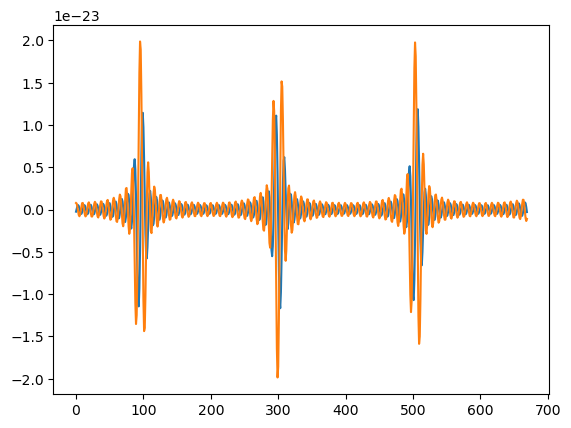

In [17]:
plt.plot(h[0][1330:2000])
plt.plot(h[1][1330:2000])
plt.show()

In [44]:
hf = np.fft.rfft(h)*dt
df = 1/(h[0].size*dt)
freqs = np.fft.rfftfreq(h[0].size, dt)
freqs[1]-df

0.0

In [49]:
np.sqrt(np.sum((np.abs(hf[0])**2+np.abs(hf[1])**2)/get_sensitivity(freqs))*df)

4.8874662143075795

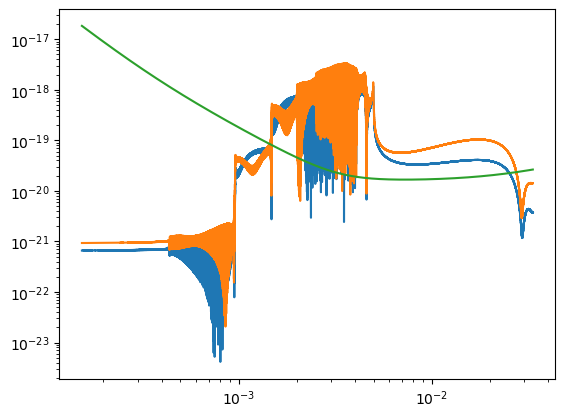

In [47]:
min_i = 10000
plt.loglog(freqs[min_i:],np.abs(hf[0][min_i:]))
plt.loglog(freqs[min_i:],np.abs(hf[1][min_i:]))
plt.loglog(freqs[min_i:],np.sqrt(get_sensitivity(freqs)[min_i:]))
plt.show()

In [19]:
h2=few(1e6, 10, 10, 0.7, 0.1, 0.5, T=0.5, dt=15)
hdist=few(1e6, 10, 10, 0.7, 0.1, 0.5, T=0.5, dt=15, dist=10)

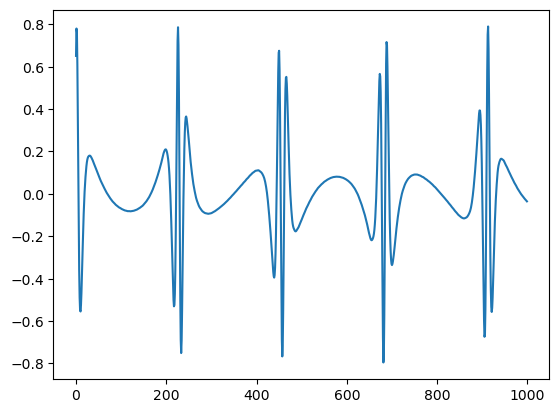

In [20]:
plt.plot(h2.real[:1000])

In [21]:
(hdist/h2)[0].real

4.785415917595429e-23

In [22]:
dist*10**9*30856775812799588

3.0856775812799587e+25

In [30]:
import astropy.constants as astroc
import astropy.units as u

In [33]:
def solar_mass_to_meters(mass):
    return mass*astroc.G*astroc.M_sun/astroc.c**2
def solar_mass_to_parsecs(mass):
    return solar_mass_to_meters(mass)/astroc.pc*u.pc

In [39]:
1-solar_mass_to_parsecs(10.)/(10e9*u.pc)/((hdist/h2)[0].real)

<Quantity 1.58831724e-08>